### SIDM with pyHalo

This notebook demonstrates how to generate realizations of self-interacting dark matter, in which a fraction of halos core collapse. 

In [1]:
from pyHalo.realization_extensions import RealizationExtensions
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from pyHalo.PresetModels.cdm import CDM
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel

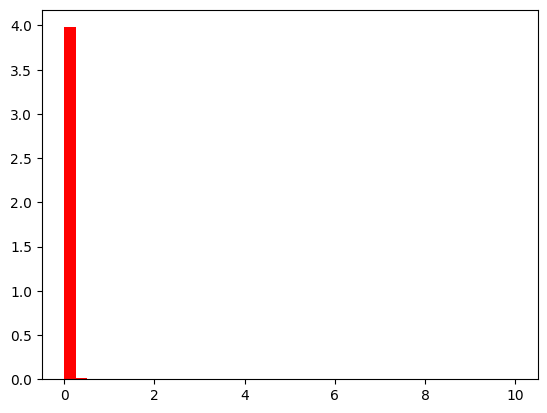

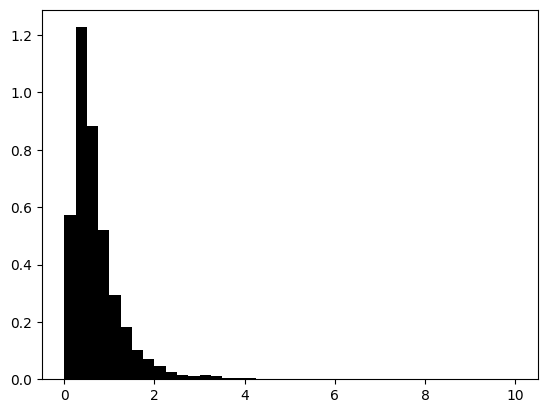

(array([0.02787207, 0.20725389, 0.39092371, 0.43451849, 0.45810255,
        0.36090763, 0.34518492, 0.30587815, 0.23512596, 0.21511524,
        0.16651778, 0.12292299, 0.10434161, 0.10219761, 0.09219225,
        0.06503484, 0.05074147, 0.04430945, 0.03430409, 0.03501876,
        0.03216009, 0.02644274, 0.01858138, 0.02215473, 0.01572271,
        0.00929069, 0.00929069, 0.0114347 , 0.00428801, 0.00714669,
        0.00500268, 0.00571735, 0.00428801, 0.00571735, 0.00285867,
        0.00714669, 0.00357334, 0.00214401, 0.00428801, 0.00428801]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
         9.  ,  9.25,  9.5 ,  9.75, 10.  ]),
 <BarContainer object of 40 artists>)

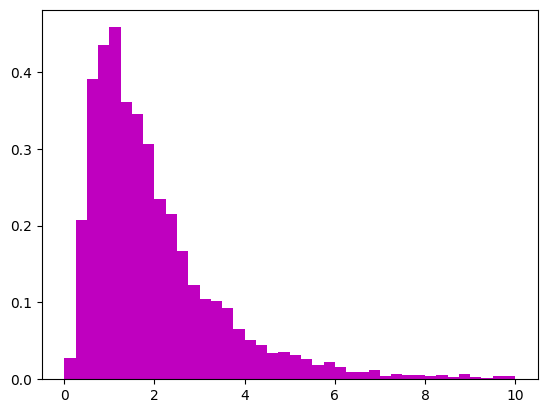

In [2]:
zlens, zsource = 0.5, 2.0
mass_ranges = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]

cdm_realization = CDM(zlens, zsource)
ext = RealizationExtensions(cdm_realization)


t0 = 2.3
subhalo_time_scaling = 1.0

s = 10.0
collapse_timescales = [t0 * s, t0 * s, t0 * s]
cdm_realization0 = ext.toSIDM(mass_ranges, collapse_timescales, subhalo_time_scaling)

s = 1.0
collapse_timescales = [t0 * s, t0 * s, t0 * s]
sidm_realization1 = ext.toSIDM(mass_ranges, collapse_timescales, subhalo_time_scaling)

s = 0.5
collapse_timescales = [t0 * s, t0 * s, t0 * s]
sidm_realization2 = ext.toSIDM(mass_ranges, collapse_timescales, subhalo_time_scaling)

s = 0.3
collapse_timescales = [t0 * s, t0 * s, t0 * s]
sidm_realization3 = ext.toSIDM(mass_ranges, collapse_timescales, subhalo_time_scaling)

t = []
for halo in sidm_realization1.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='r',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization2.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='k',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization3.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='m',density=True, bins=40,range=(0, 10))

### Now we can compute the effective multiplane convergence with SIDM halos

In [3]:
npix = 200 
grid_resolution_critcurves = 0.04
grid_size = 1.5
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

residual_kappa_map_list = []
ra_crit_list_list = []
dec_crit_list_list = []

for sidm_realization in [cdm_realization0, sidm_realization1, sidm_realization2, sidm_realization3]:
    print(sidm_realization)
    
    lens_model_list, lens_redshift_array, kwargs_halos, _ = sidm_realization.lensing_quantities()

    astropy_instance = sidm_realization.astropy_instance

    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=None)


    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)
    residual_kappa_map_list.append(kappa_full - kappa_macro)

    lens_model_extension = LensModelExtensions(lens_model_full)
    
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, 
                                                                grid_scale=grid_resolution_critcurves)
    ra_crit_list_list.append(ra_crit_list)
    dec_crit_list_list.append(dec_crit_list)


### Make the figure

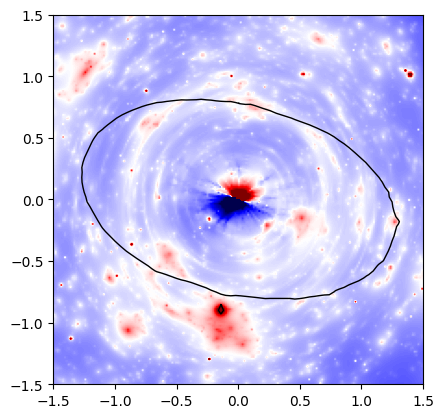

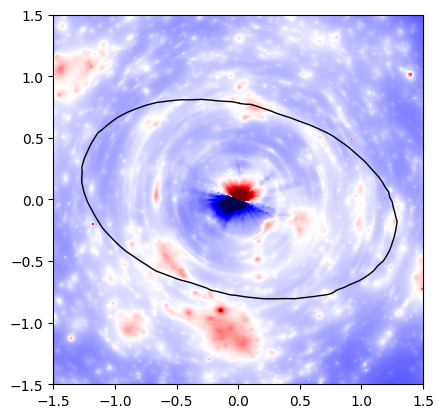

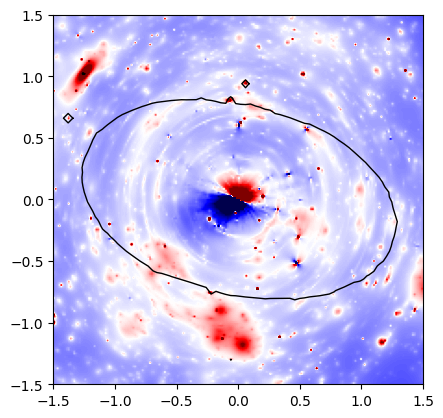

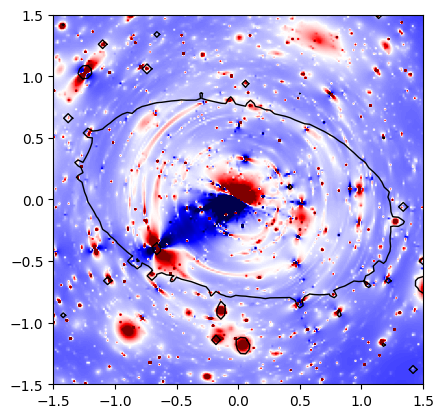

In [4]:
for (kap, rac, dec) in zip(residual_kappa_map_list, ra_crit_list_list, dec_crit_list_list):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.imshow(kap, vmin=-0.1, vmax=0.1, cmap='seismic',
             extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
    for i in range(0, len(rac)):
        ax.plot(rac[i], dec[i], color='k', lw=1)
    plt.show()

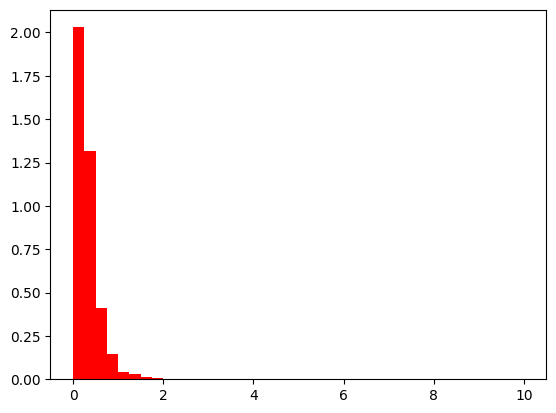

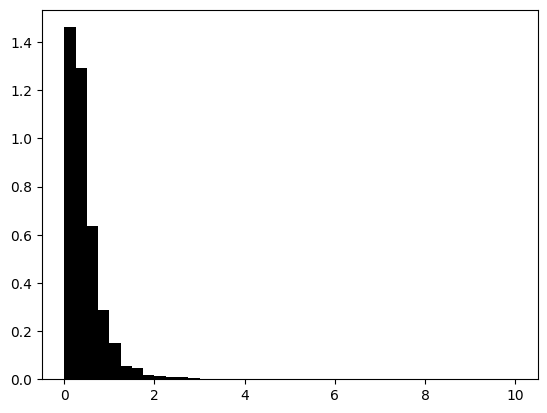

(array([1.15738929e+00, 9.57495999e-01, 5.60554864e-01, 3.96941135e-01,
        2.83122888e-01, 1.77129646e-01, 1.27334163e-01, 9.31886893e-02,
        6.82909479e-02, 4.69500267e-02, 2.70318335e-02, 1.42272808e-02,
        1.77841010e-02, 1.77841010e-02, 9.24773253e-03, 5.69091232e-03,
        7.82500445e-03, 6.40227636e-03, 2.13409212e-03, 4.97954828e-03,
        5.69091232e-03, 1.42272808e-03, 2.84545616e-03, 1.42272808e-03,
        7.11364041e-04, 1.42272808e-03, 1.42272808e-03, 0.00000000e+00,
        0.00000000e+00, 7.11364041e-04, 7.11364041e-04, 7.11364041e-04,
        0.00000000e+00, 7.11364041e-04, 0.00000000e+00, 0.00000000e+00,
        7.11364041e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  

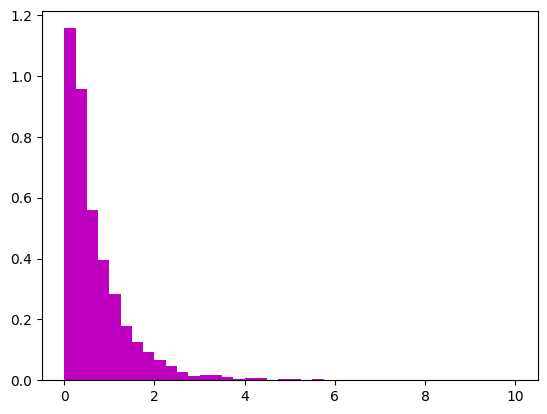

In [5]:
t0 = 1.5
s = 1.0

subhalo_time_scaling = 1.0
collapse_timescales = [t0 * s, t0 * s, t0 * s]
sidm_realization1 = ext.toSIDM(mass_ranges, collapse_timescales, subhalo_time_scaling)

subhalo_time_scaling = 2.0
collapse_timescales = [t0 * s, t0 * s, t0 * s]
sidm_realization2 = ext.toSIDM(mass_ranges, collapse_timescales, subhalo_time_scaling)

subhalo_time_scaling = 4.0
collapse_timescales = [t0 * s, t0 * s, t0 * s]
sidm_realization3 = ext.toSIDM(mass_ranges, collapse_timescales, subhalo_time_scaling)

t = []
for halo in sidm_realization1.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='r',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization2.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='k',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization3.halos:
    t.append(halo.t_over_tc)
plt.hist(t, color='m',density=True, bins=40,range=(0, 10))

In [6]:
npix = 200 
grid_resolution_critcurves = 0.04
grid_size = 1.5
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

residual_kappa_map_list = []
ra_crit_list_list = []
dec_crit_list_list = []

for sidm_realization in [cdm_realization0, sidm_realization1, sidm_realization2, sidm_realization3]:
    print(sidm_realization)
    
    lens_model_list, lens_redshift_array, kwargs_halos, _ = sidm_realization.lensing_quantities()

    astropy_instance = sidm_realization.astropy_instance

    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=None)


    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)
    residual_kappa_map_list.append(kappa_full - kappa_macro)

    lens_model_extension = LensModelExtensions(lens_model_full)
    
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, 
                                                                grid_scale=grid_resolution_critcurves)
    ra_crit_list_list.append(ra_crit_list)
    dec_crit_list_list.append(dec_crit_list)


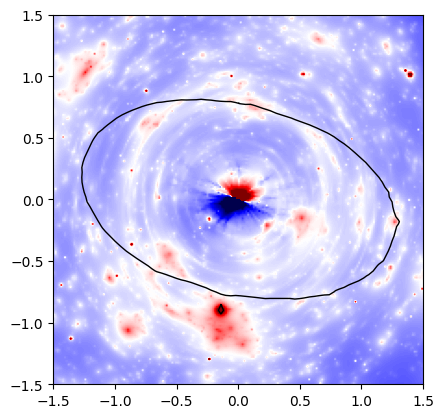

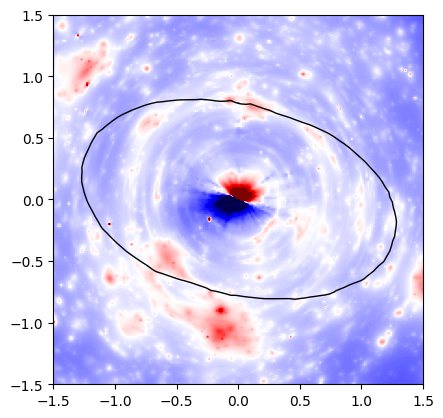

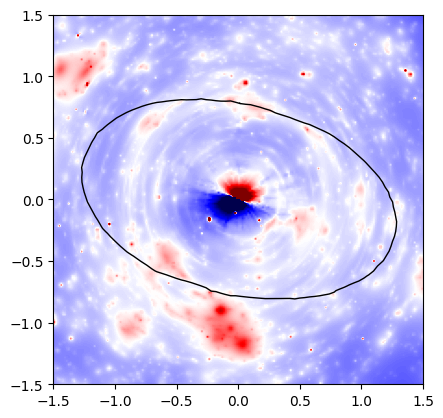

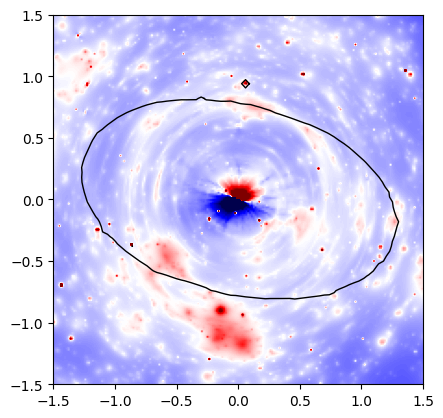

In [7]:
for (kap, rac, dec) in zip(residual_kappa_map_list, ra_crit_list_list, dec_crit_list_list):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.imshow(kap, vmin=-0.1, vmax=0.1, cmap='seismic',
             extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
    for i in range(0, len(rac)):
        ax.plot(rac[i], dec[i], color='k', lw=1)
    plt.show()